# Visualising CLIP #

### Abstract ###

- Code stripped from [@fuguer in Unstable Diffusion](https://discord.com/channels/1010980909568245801/1011105234820542554/1230930560956760185)
- Notebook skeleton borrowed from [view_unet.ipynb](./v2a/view_unet.ipynb)

### Required libraries ###

- ~~Should be the common ML pack we're using. Also with [SD webui's dependency](https://github.com/AUTOMATIC1111/stable-diffusion-webui).~~

- [sklearn](https://scikit-learn.org/stable/)
- [safetensors](https://huggingface.co/docs/safetensors/index)
- [diffusers](https://huggingface.co/docs/diffusers/installation)
- [pytorch](https://pytorch.org/get-started/locally/#windows-python)
- [Graphviz](https://graphviz.org/)
- [pandas](https://pandas.pydata.org/)

## Importing libraries ##

In [18]:
import math
import os
import pandas as pd
import numpy as np
from scipy.spatial import distance_matrix

import torch
from safetensors.torch import load_file #safe_open
from diffusers import StableDiffusionXLPipeline

import matplotlib.markers as mks
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

from tqdm import tqdm

In [19]:
torch.__version__

'2.2.1+cu121'

In [20]:
torch.cuda.is_available()

True

In [21]:
# Fix for OMP: Error #15
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [22]:
# TODO: Support 'cuda', but 'cpu' is arleady fast.
g_device = "cuda:1" #"cpu"
# Currently for generating graph only.
g_seed = 114514

In [23]:
DIR_BASE = "F:/NOVELAI/astolfo_mix/sdxl/" #To set up merger
DIR_RAW = "view_clip/" #To load N models

PROMPTS_FOR_EMB = "./1000-most-common-words.txt" #1 line per prompt

In [24]:
MECHA_RECIPE_EXT = ".mecha"
MECHA_MODEL_EXT = ".safetensors"

MODEL_LIST_RAW = os.listdir("{}{}".format(DIR_BASE,DIR_RAW))
# Exclude yaml.
MODEL_LIST_RAW = list(filter(lambda p: p.endswith(MECHA_MODEL_EXT), MODEL_LIST_RAW)) #p.endswith(".ckpt") or p.endswith(".safetensors") or p.endswith(".bin")
#if len(MODEL_LIST_RAW) < 2:
#    raise Exception("Need at least 2 models for merge.")
#model_list = list(map(lambda p: os.path.splitext(os.path.basename(p))[0], model_list))

In [25]:
print("{} raw models found.".format(len(MODEL_LIST_RAW)))

81 raw models found.


In [26]:
RESULT_CSV_DIR = "./result_csv"
RESULT_PLT = "./result.png"

## Start dumping original codes. ##

This is actually doing what [mega_cmp](https://github.com/6DammK9/nai-anime-pure-negative-prompt/blob/main/ch03/v2a/mega_cmp.ipynb) does.

In [27]:
def compute_distances(model_paths, text_dict, device="cuda"):
    results = {
        "Cosine": {},
        "Euclidean": {},
        "Manhattan": {},
        "Lengths": {},  # Store the lengths of embeddings here
        "Embeddings": {},
    }

    for model_path in tqdm(model_paths, desc='Obtaining prompt embeddings from model', position=0):
        pipeline = StableDiffusionXLPipeline.from_single_file(os.path.join("{}{}".format(DIR_BASE,DIR_RAW), model_path), use_safetensors=True)
        pipeline.to(device)
        tokenizer = pipeline.tokenizer_2
        text_encoder = pipeline.text_encoder_2

        # Extract text list for tokenization
        text_list = list(text_dict.values())

        # Tokenize the input text
        text_input_ids = tokenizer(
            text_list, truncation=True, padding="max_length", max_length=tokenizer.model_max_length, return_tensors="pt"
        ).input_ids.to(device)
        # tokens_one = tokenizers[0](
        #     captions, truncation=True, padding="max_length", max_length=tokenizers[0].model_max_length, return_tensors="pt"
        # ).input_ids 

        clip_skip = 2
        #enc_out = text_encoder(tokens, output_hidden_states=True, return_dict=True)

        prompt_embeds = text_encoder(
            text_input_ids.to(text_encoder.device),
            output_hidden_states=True,
        )

        pooled_prompt_embeds = prompt_embeds[0]
        
        clip_skip = 1
        prompt_embeds = prompt_embeds.hidden_states[-clip_skip]
        bs_embed, seq_len, _ = prompt_embeds.shape
        prompt_embeds = prompt_embeds.view(bs_embed, seq_len, -1)

        prompt_embeds = prompt_embeds.view(bs_embed, -1) # stack the sequences onto embeddings
        prompt_embeds = prompt_embeds / prompt_embeds.norm(dim=1, keepdim=True)

        
        # Compute cosine similarities
        
        cosine_similarities = torch.mm(prompt_embeds, prompt_embeds.T)

        # Compute Euclidean and Manhattan distances
        embeddings_np = prompt_embeds.cpu().numpy()
        euclidean_distances = distance_matrix(embeddings_np, embeddings_np)
        manhattan_distances = distance_matrix(embeddings_np, embeddings_np, p=1)

        # Store results
        model_name = os.path.basename(model_path)
        index_labels = list(text_dict.keys())
        results["Cosine"][model_name] = pd.DataFrame(cosine_similarities.cpu().numpy(), index=index_labels, columns=index_labels)
        results["Euclidean"][model_name] = pd.DataFrame(euclidean_distances, index=index_labels, columns=index_labels)
        results["Manhattan"][model_name] = pd.DataFrame(manhattan_distances, index=index_labels, columns=index_labels)
        #results["Lengths"][model_name] = embedding_lengths.cpu().numpy()
        results['Embeddings'][model_name] = embeddings_np

    return results

Console log is a bad idea. I modify it to output as CSV.

In [28]:
def print_results(results, decimals=3, log_file_dir="./result_csv"):
    for distance_type, models in results.items():
        if distance_type == 'Embeddings':
            continue #It is NOT a distance 
        for model_name, df in models.items():
            #Sometimes it is ndarray, cast to pd.DataFrame again
            df = pd.DataFrame(df)
            #print(f"\nModel: {model_name}")    
            formatted_df = df.round(decimals)            
            #print(formatted_df)
            formatted_df.to_csv('{}/{}-{}.csv'.format(log_file_dir, distance_type, model_name))  
        #print("\n" + "-"*40)

Plot will be adjusted to a huge square (like xyplot in A1111)

In [29]:
def visualize_embeddings(embeddings_dict, text_dict, markers_dict, method='tsne', n_components=2, random_state=42, plt_path="./result.png"):
    n_models = len(embeddings_dict)
    n_cols = math.ceil(math.sqrt(len(embeddings_dict.items()))) #3  # Adjust based on how many columns you want in your subplot grid
    n_rows = (n_models + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 6))
    axes = axes.flatten()

    for idx, (model_name, embeddings) in tqdm(enumerate(embeddings_dict.items()), desc='Generating plots', position=0):
        if method == 'tsne':
            embeddings_reduced = TSNE(n_components=n_components, perplexity=min(len(embeddings) - 1, 30), random_state=random_state).fit_transform(embeddings)
        elif method == 'pca':
            pca = PCA(n_components=n_components, random_state=random_state)
            embeddings_reduced = pca.fit_transform(embeddings)
            # Capture the explained variance ratios for PCA1 and PCA2
            explained_var_ratio = pca.explained_variance_ratio_ * 100  # Convert to percentage
        else:
            raise ValueError("Method must be 'tsne' or 'pca'.")

        ax = axes[idx]
        scatter_plots = []
        for i, (label, text) in enumerate(text_dict.items()):
            marker = markers_dict.get(label, 'o')
            scatter = ax.scatter(embeddings_reduced[i, 0], embeddings_reduced[i, 1], label=text, marker=marker)
            scatter_plots.append(scatter)
        ax.set_title(f'{method.upper()} of {model_name}')

        if method == 'pca':
            # Set the axis labels with the explained variance
            ax.set_xlabel(f'PCA1 - {explained_var_ratio[0]:.2f}%')
            ax.set_ylabel(f'PCA2 - {explained_var_ratio[1]:.2f}%')

        # Only place the legend in the rightmost column plots
        # Top right corners instead!
        if (idx + 1) == n_cols:
            ax.legend(handles=scatter_plots, loc='center left', bbox_to_anchor=(1, 0.5), ncol=1 if len(text_dict) <= 10 else 2)

    # Hide unused subplots
    for i in range(n_models, n_rows * n_cols):
        axes[i].axis('off')

    plt.tight_layout(pad=3.0)
    plt.subplots_adjust(right=0.8 if n_cols > 1 else 0.95)  # Adjust right edge to fit legends if multiple columns
    plt.savefig(plt_path)
    plt.show()

Instead of hardcoding the prompts for embeddings, let's use a corpus txt instead.

Example corpus ["1000-most-common-words.txt"](https://github.com/powerlanguage/word-lists/blob/master/1000-most-common-words.txt)

In [30]:
# Why do indexing? Later will use actual dataset (danbooru tags / NLP corpus etc.))
corpus = []

with open(PROMPTS_FOR_EMB, "r") as corpus_file:
    corpus = corpus_file.readlines()

# Prevent OOM
CORPUS_LIMIT = 192
corpus = corpus[-CORPUS_LIMIT:]

In [31]:
print("Corpus size: {}".format(len(corpus)))

Corpus size: 192


In [32]:
# Main setup
device = g_device

text_dict = {}
markers_dict = {}

for i, c in enumerate(corpus):
    text_dict[str(i)] = c

#https://matplotlib.org/stable/api/_as_gen/matplotlib.markers.MarkerStyle.html#matplotlib.markers.MarkerStyle
filled_markers = list(mks.MarkerStyle.filled_markers)

for i, c in enumerate(corpus):
    markers_dict[str(i)] = mks.MarkerStyle.filled_markers[i % len(filled_markers)]

model_paths = MODEL_LIST_RAW

In [33]:
main_result = {}

In [34]:
with torch.no_grad():
    # Compute distances
    main_result = compute_distances(model_paths, text_dict)

Obtaining prompt embeddings from model: 100%|██████████| 81/81 [2:52:59<00:00, 128.14s/it]  


In [35]:
# Print results organized by distance type, then by model
# Not interested
#print_results(main_result, 4, RESULT_CSV_DIR)

Generating plots: 81it [00:42,  1.89it/s]
C:\Users\User\AppData\Local\Temp\ipykernel_31176\2390567953.py:42: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout(pad=3.0)


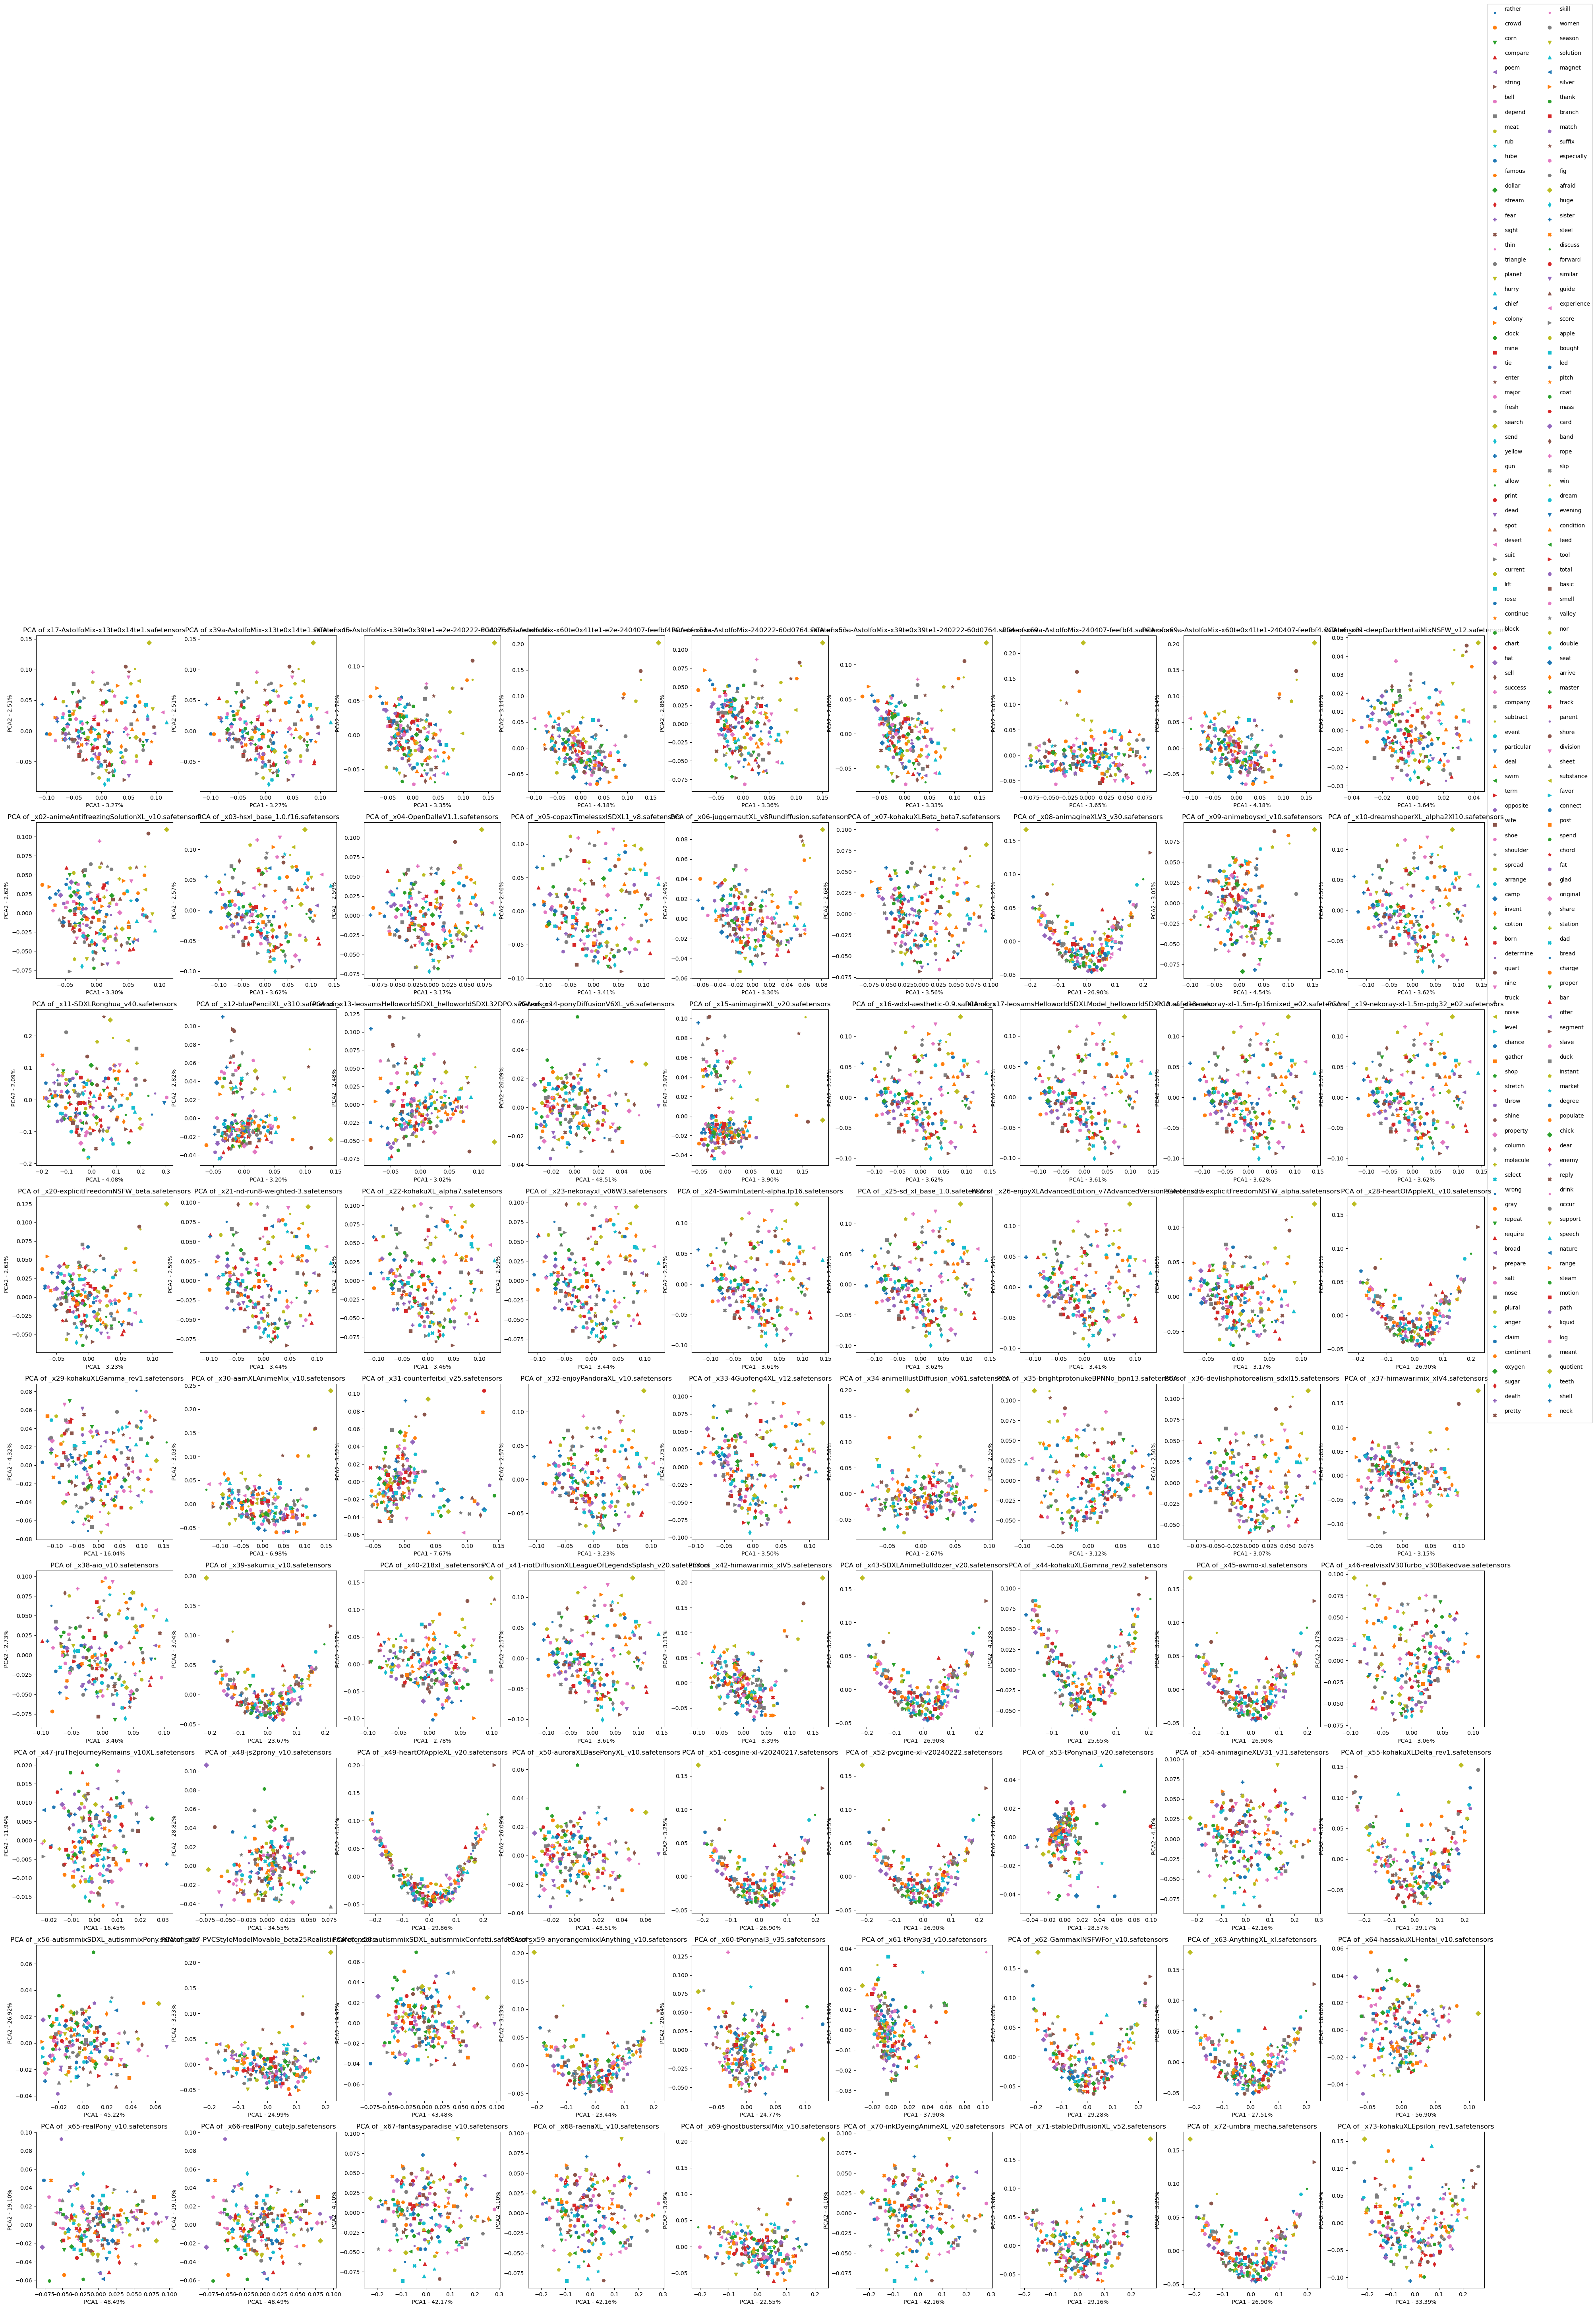

In [36]:
#Must be 2 components only because the plot is a 2D image.
IMAGE_DIM = 2
visualize_embeddings(main_result['Embeddings'], text_dict, markers_dict, method='pca', n_components=IMAGE_DIM, random_state=g_seed, plt_path=RESULT_PLT)
#visualize_embeddings(main_result['Embeddings'], text_dict, markers_dict, method='tsne')